In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys
import glob
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scripts.utils import train_keys
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import pickle
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.AutoEncoder import EncoderBig, DecoderBig, EncoderHuge, DecoderHuge
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

X_train, Y_train = train_data.iloc[:,:15].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

X_val, Y_val = validation_data.iloc[:,:15].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [4]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

In [5]:
model =  tf.keras.models.load_model('saved_model/classifier_model')

2022-03-15 17:01:32.708255: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-15 17:01:32.708722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-15 17:01:32.708826: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
predictions = model.predict(x_val)

2022-03-15 17:01:33.304184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-15 17:01:33.304980: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


In [7]:
def calculate_entropy(pred):
    entropy = -pred*np.log2(pred) - (1-pred)*np.log2(1-pred)
    return entropy

In [8]:
entropy = calculate_entropy(predictions)

/tmp/ipykernel_65699/2455310525.py:2: RuntimeWarning: divide by zero encountered in log2
  entropy = -pred*np.log2(pred) - (1-pred)*np.log2(1-pred)
/tmp/ipykernel_65699/2455310525.py:2: RuntimeWarning: invalid value encountered in multiply
  entropy = -pred*np.log2(pred) - (1-pred)*np.log2(1-pred)


<IPython.core.display.Javascript object>


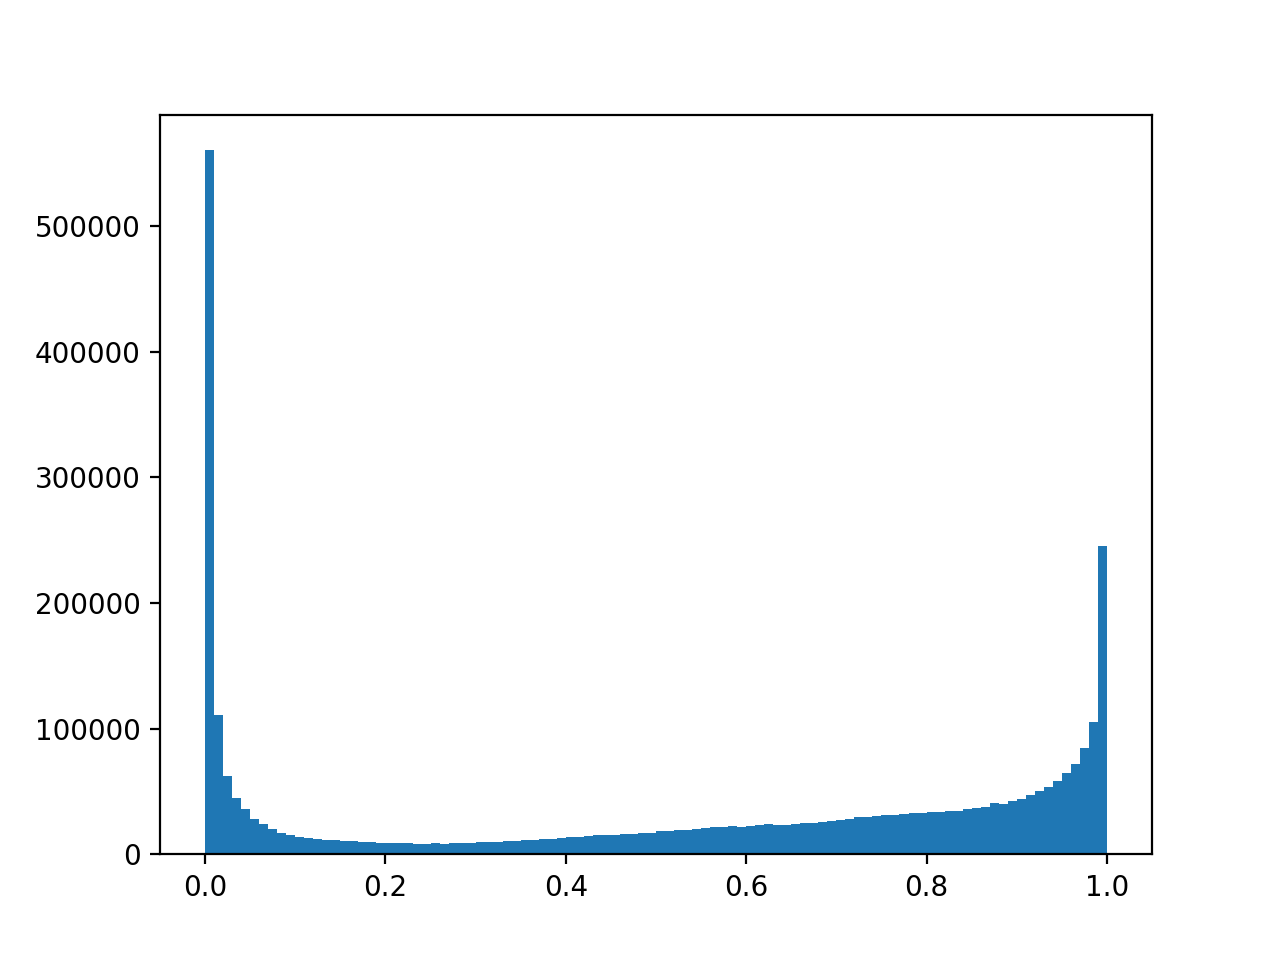

In [9]:
plt.figure()
bins,_,_ = plt.hist(entropy, bins = 100)

<IPython.core.display.Javascript object>


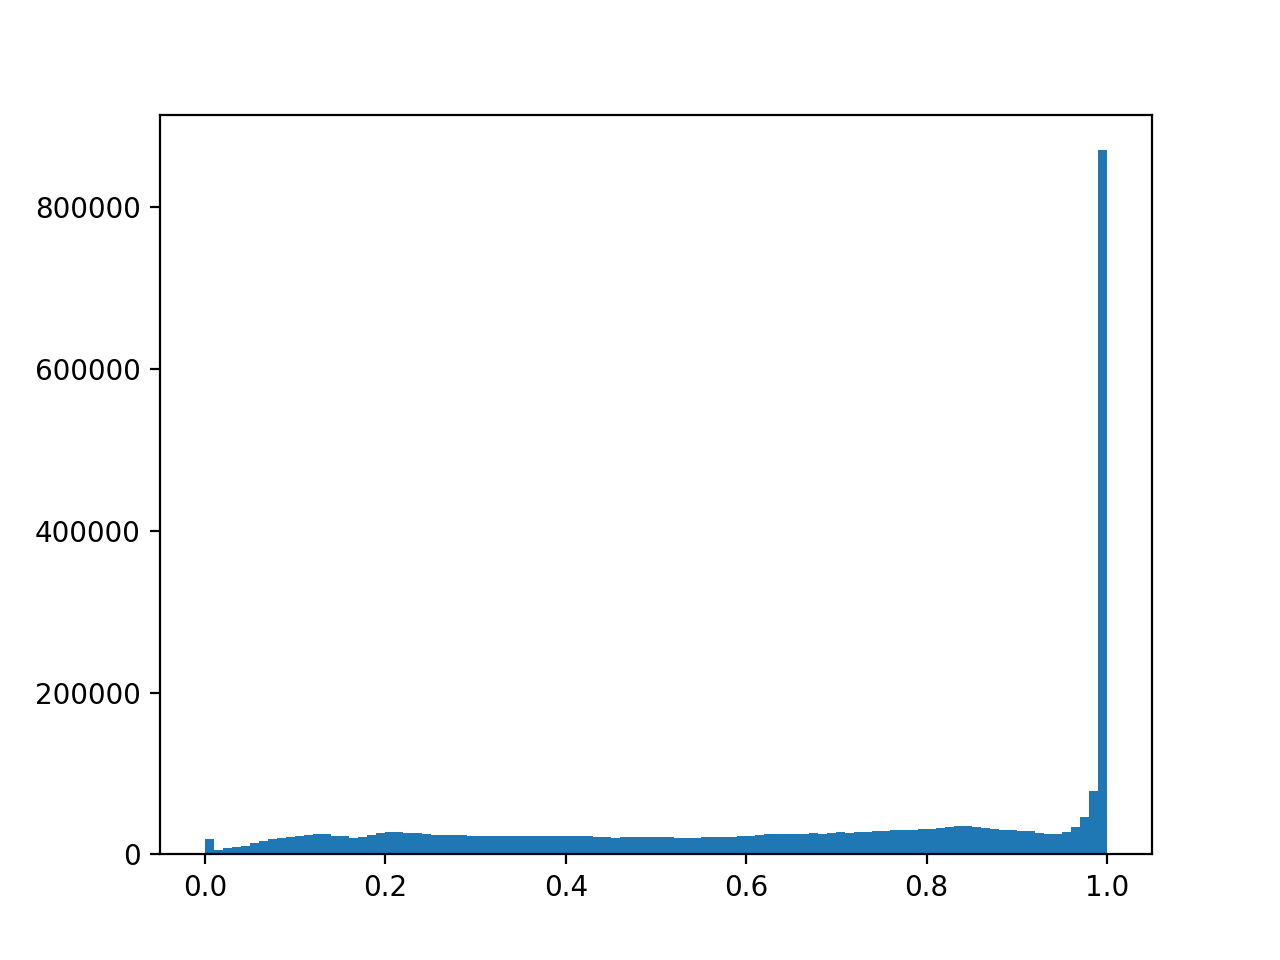

In [10]:
plt.figure()
plt.hist(predictions, bins = 100);

In [13]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-16/experiment_name=0-epoch=163-val_loss=0.03.ckpt"
modelAE = AutoEncoder.load_from_checkpoint(path, encoder = EncoderHuge, decoder = DecoderHuge,
                                         n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.001)
encoder = modelAE.encoder

In [14]:
outputs = encoder(torch.tensor(x_val))

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
outputs = outputs.detach().numpy()

<IPython.core.display.Javascript object>


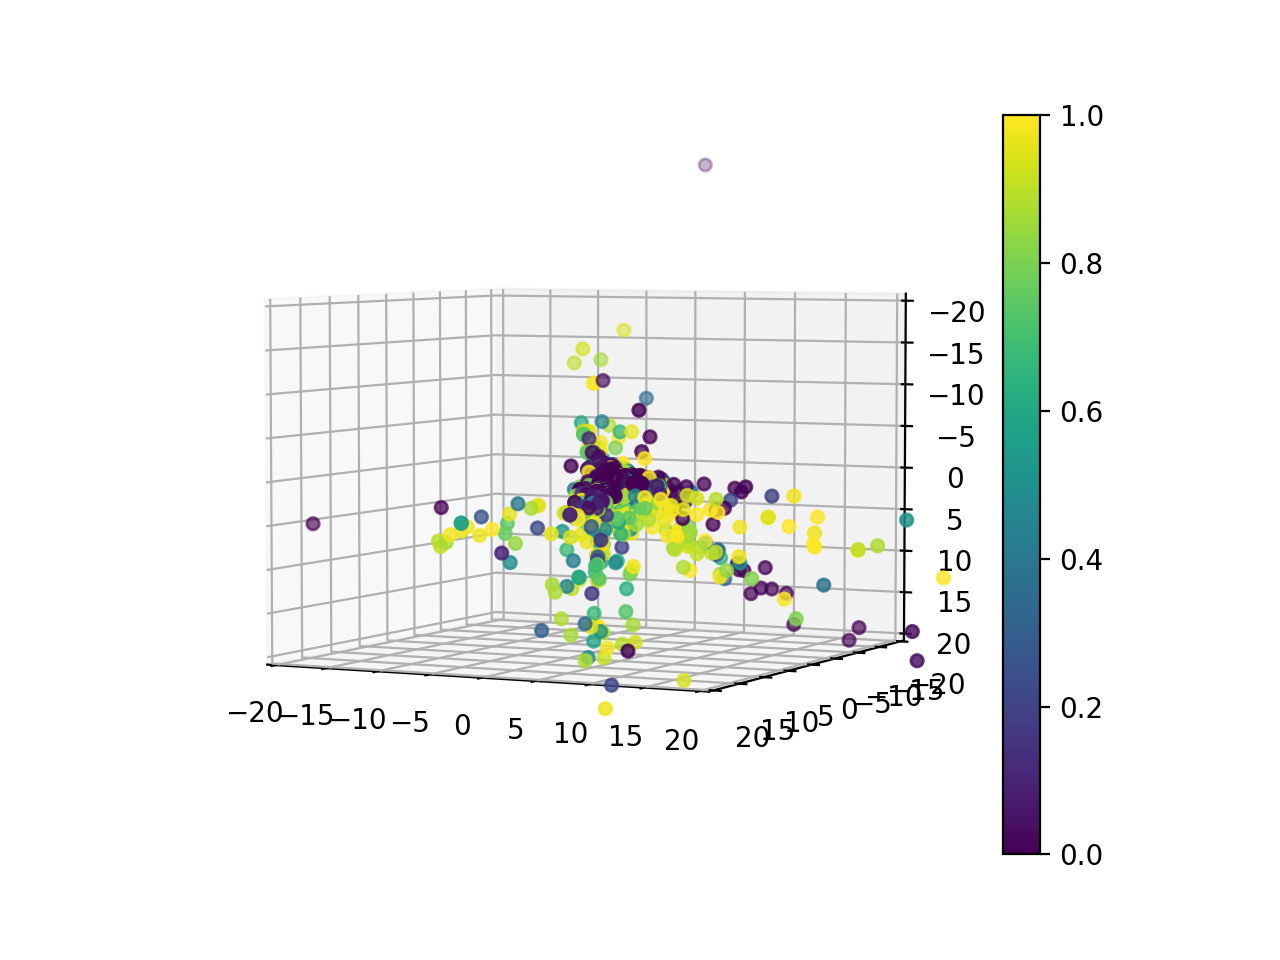

In [17]:
n = 10_000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(outputs[:n,0], outputs[:n,1],outputs[:n,2], c = entropy[:n])
fig.colorbar(p)

ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_zlim(-20,20)
fig.show()


In [36]:
entropy = entropy.reshape((entropy.shape[0],))

<IPython.core.display.Javascript object>


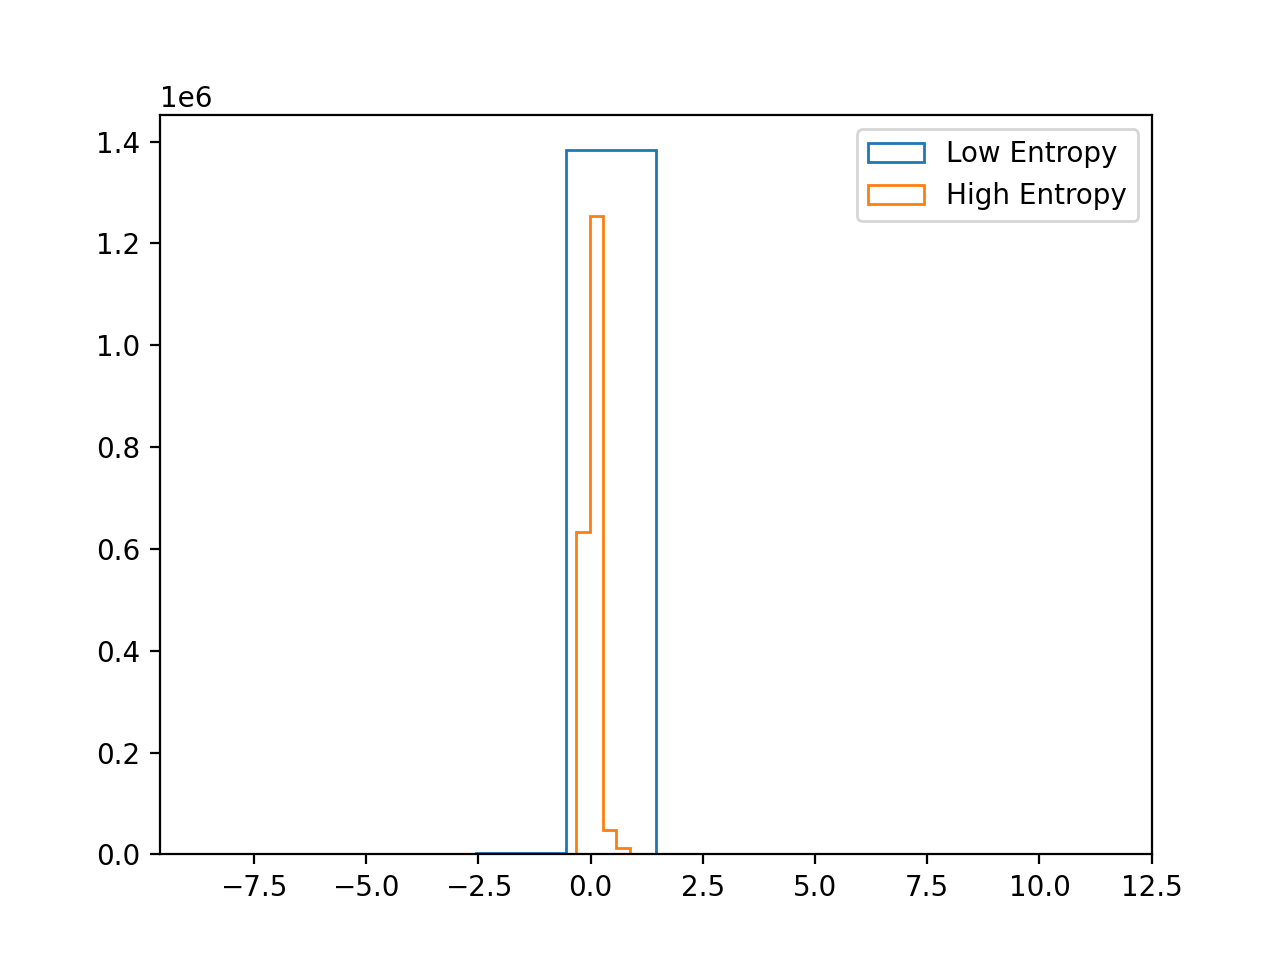

<IPython.core.display.Javascript object>


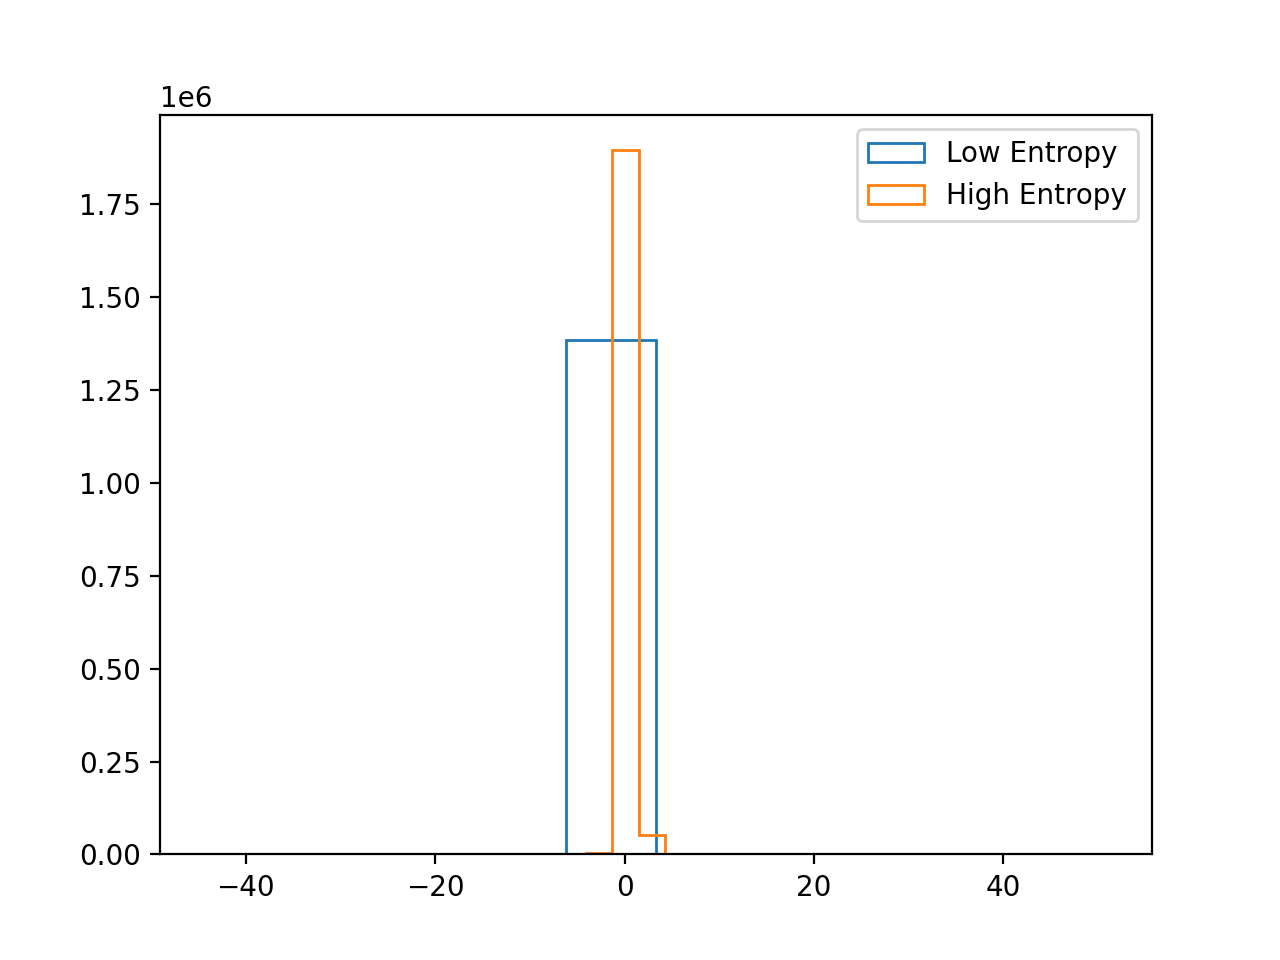

<IPython.core.display.Javascript object>


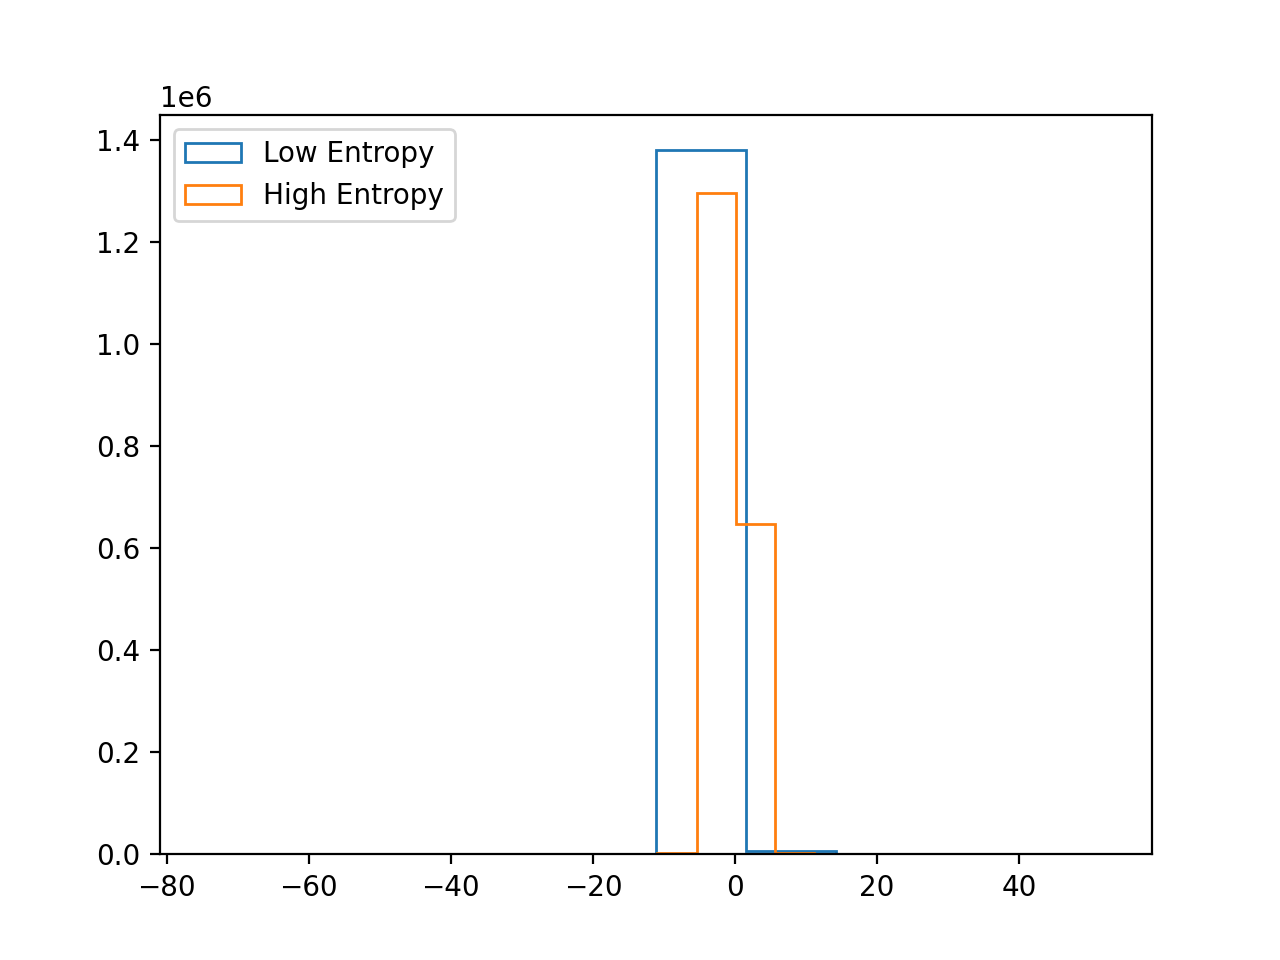

<IPython.core.display.Javascript object>


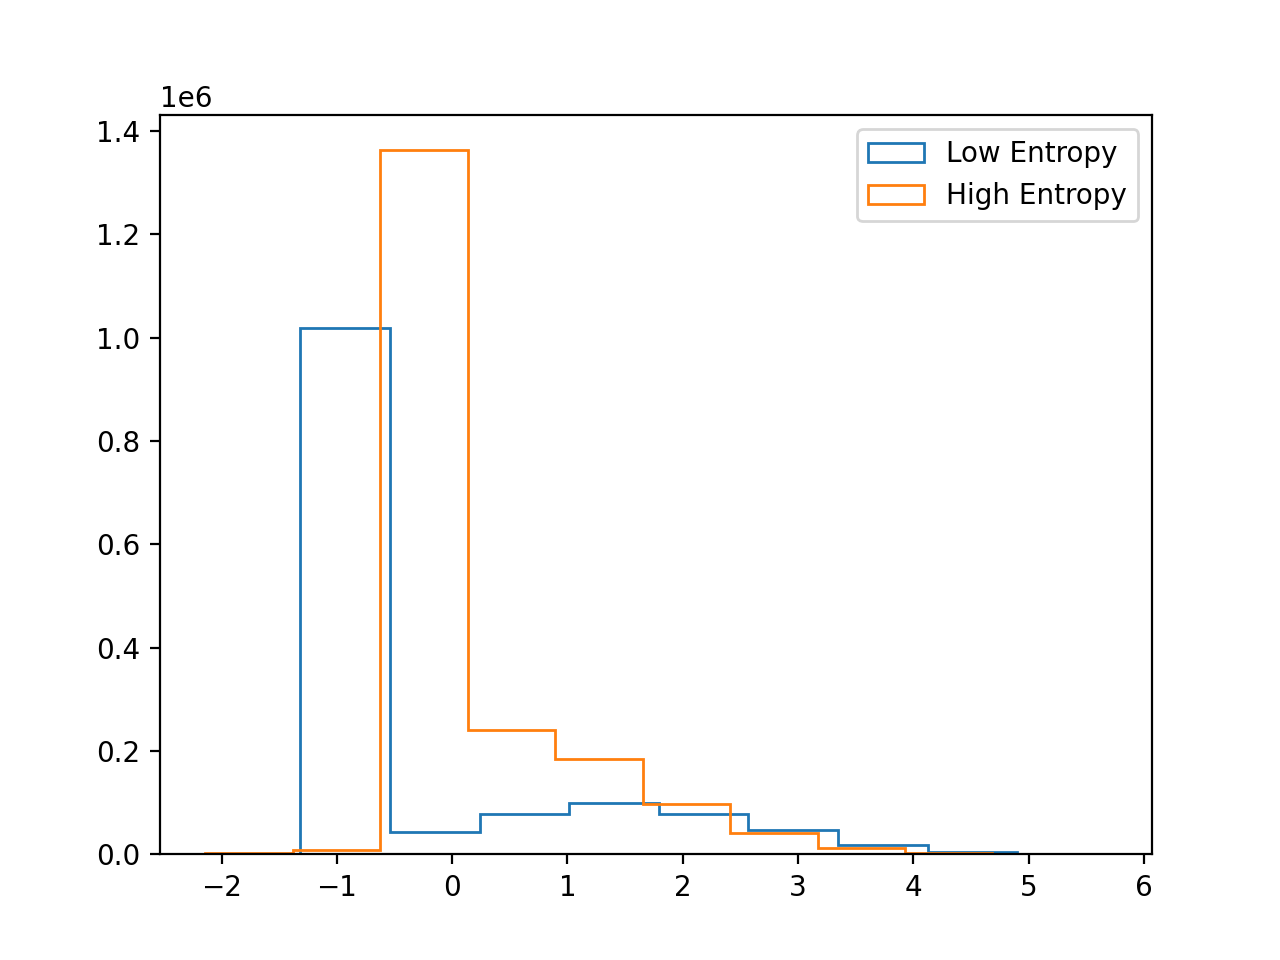

<IPython.core.display.Javascript object>


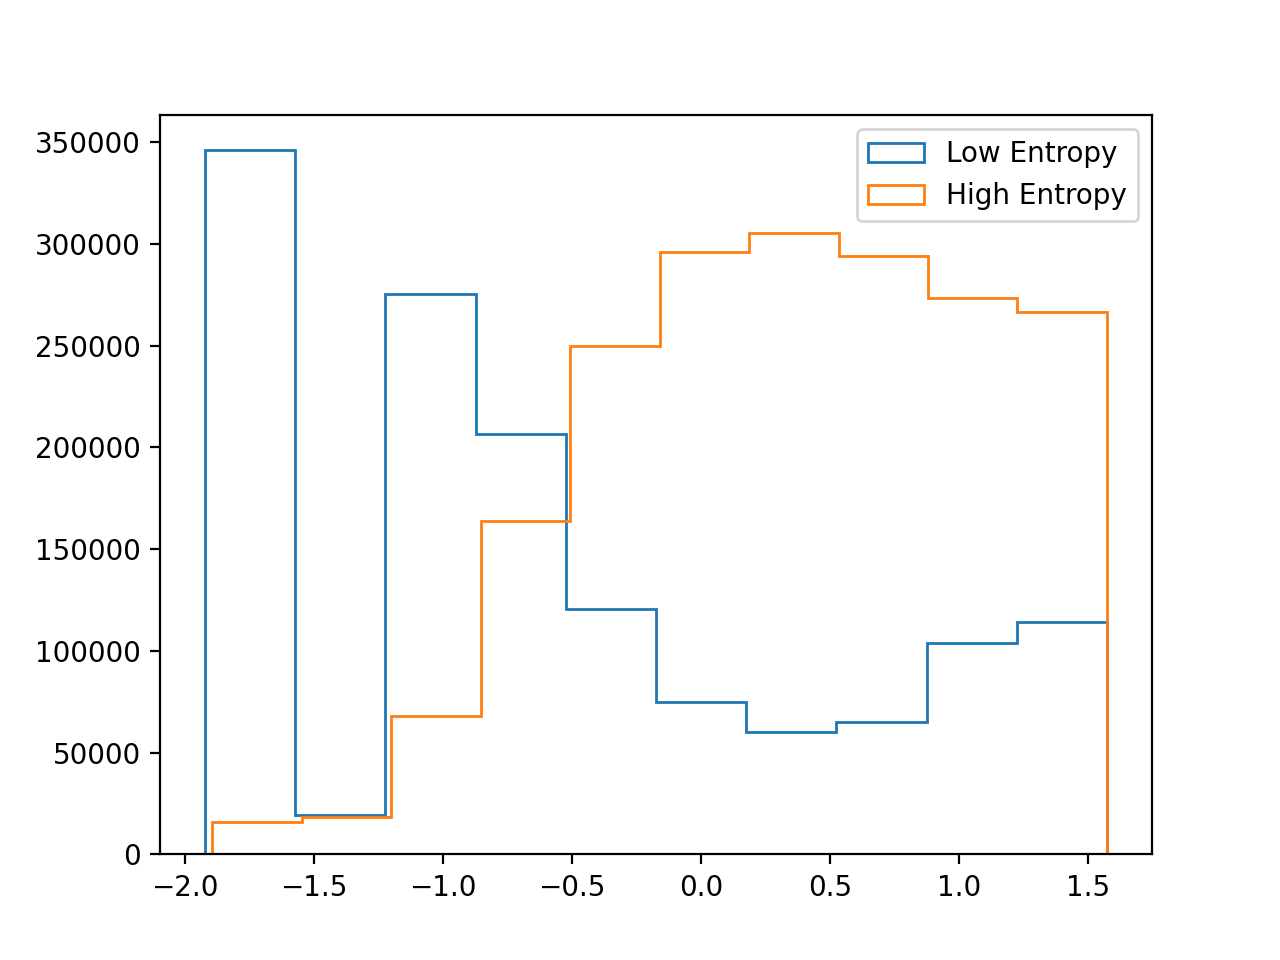

<IPython.core.display.Javascript object>


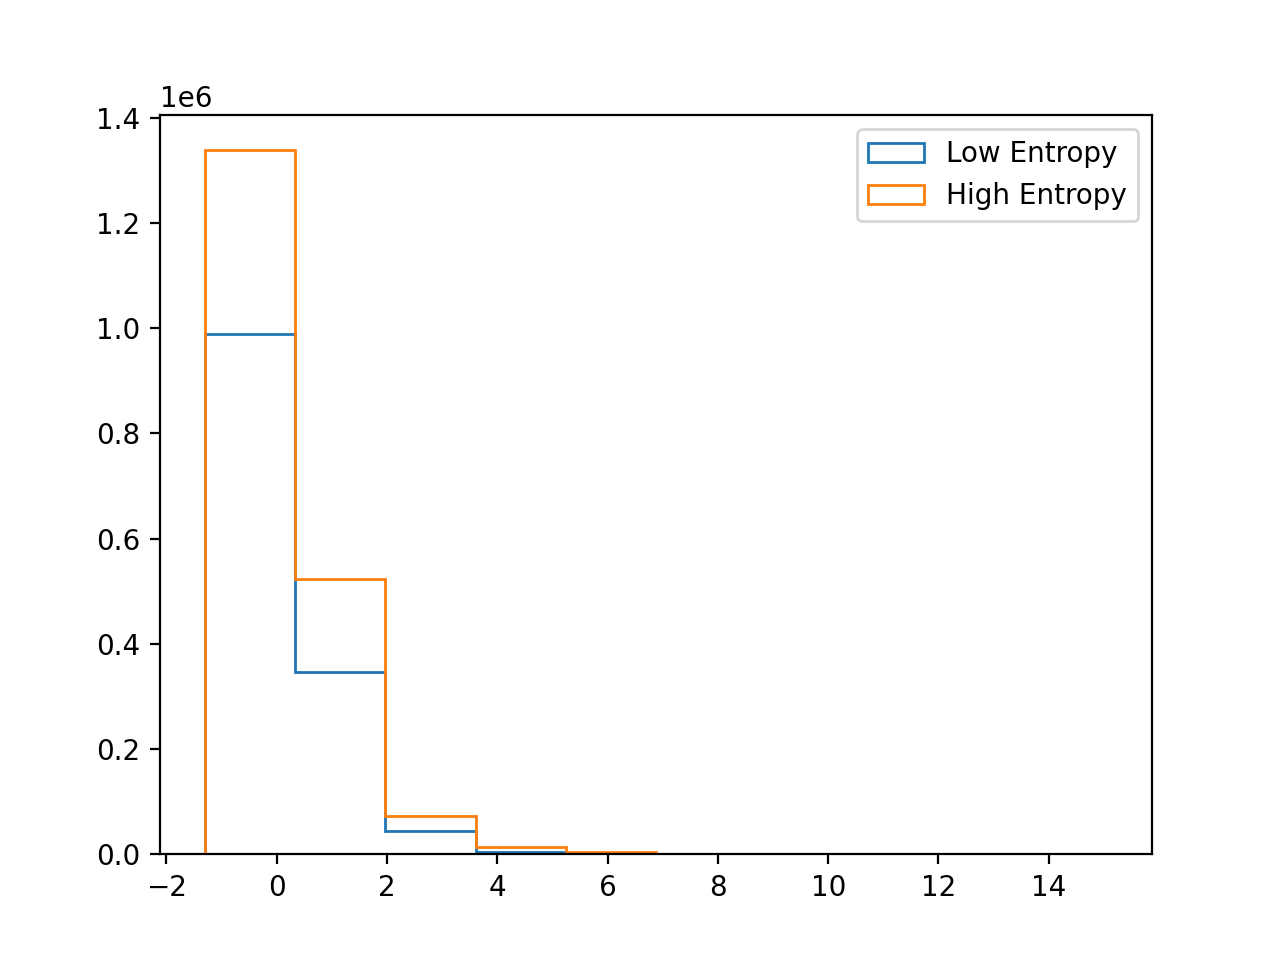

<IPython.core.display.Javascript object>


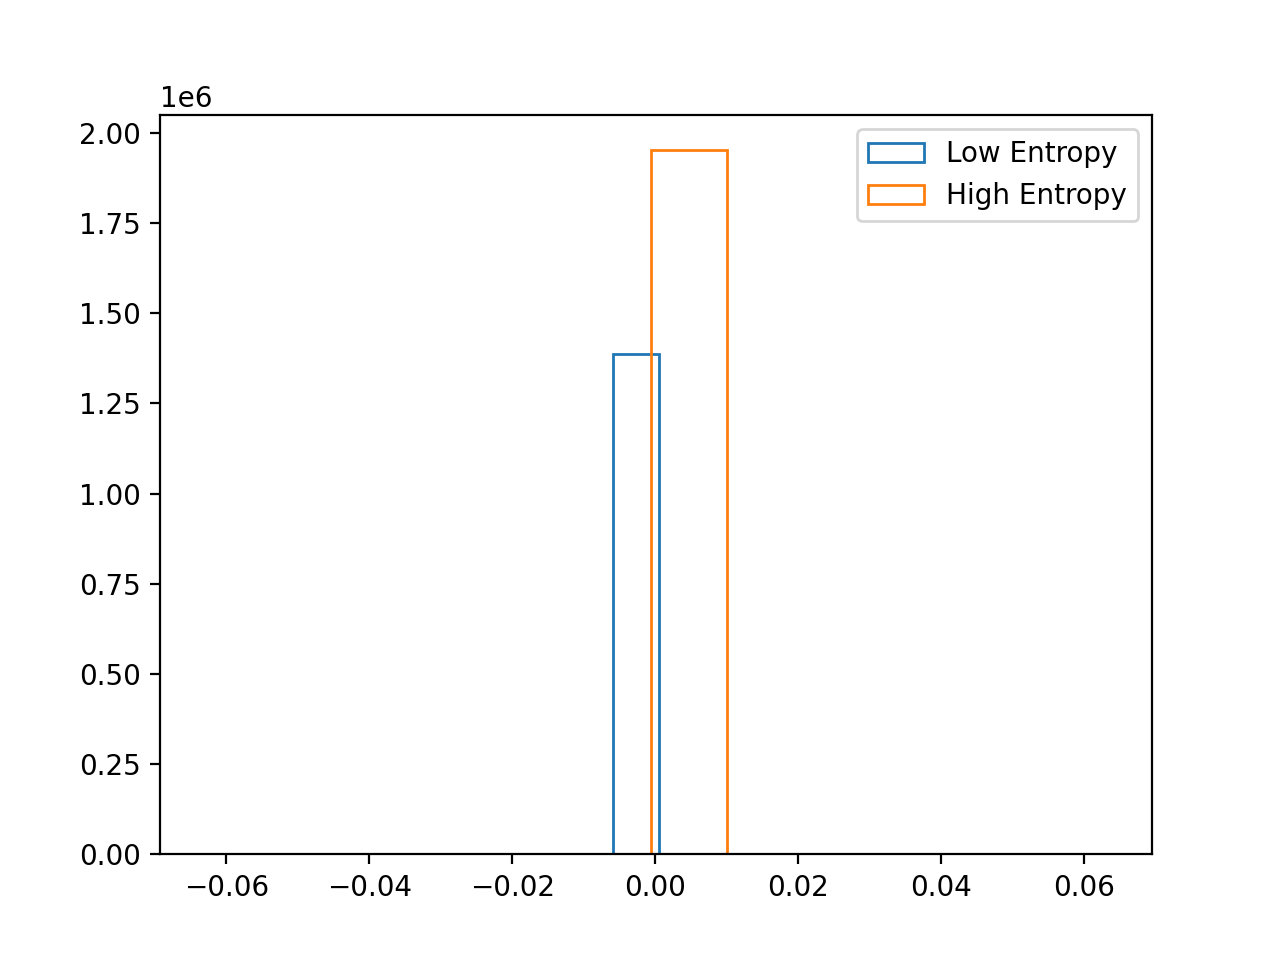

<IPython.core.display.Javascript object>


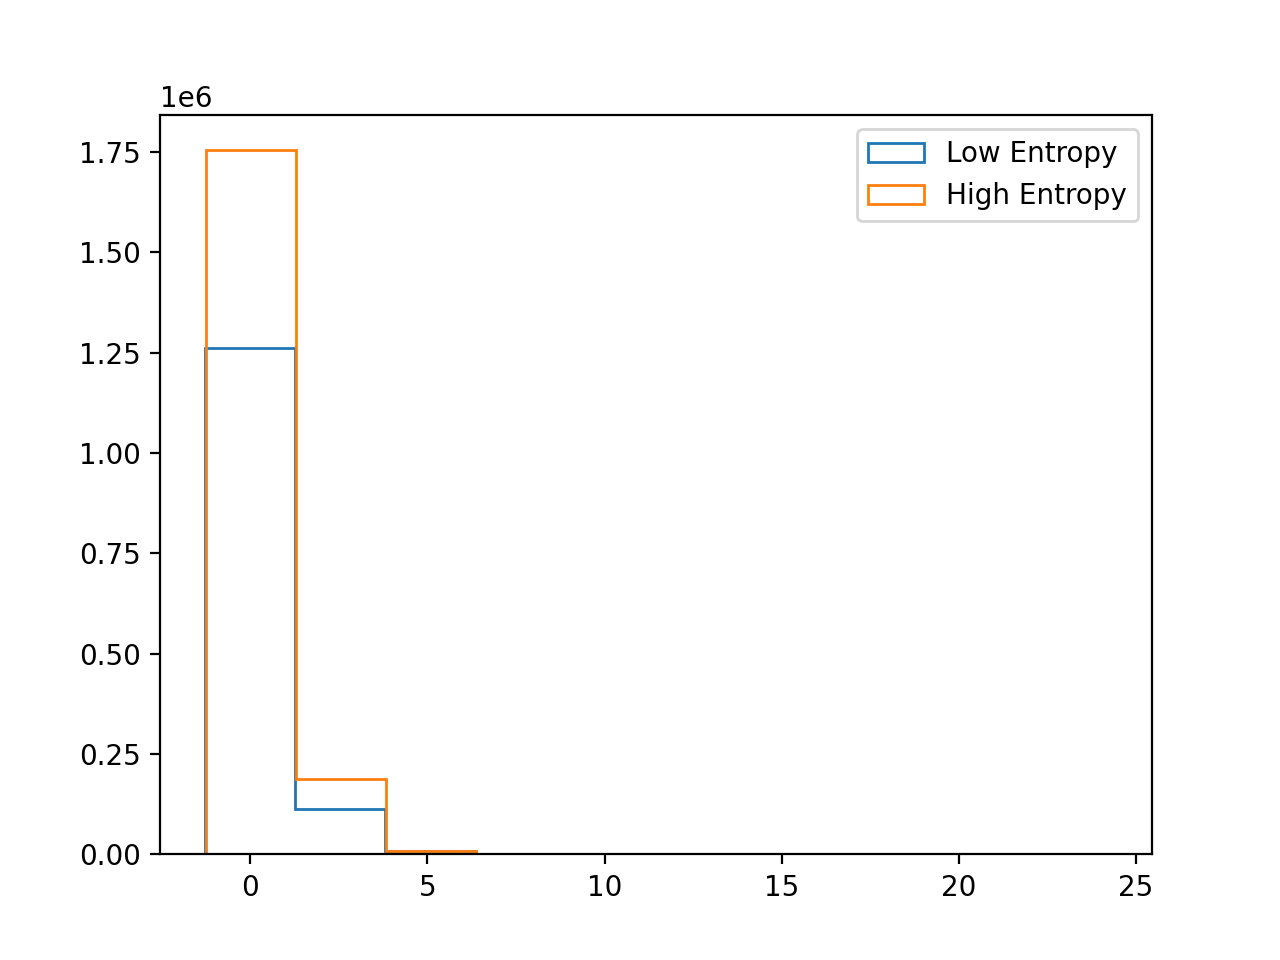

<IPython.core.display.Javascript object>


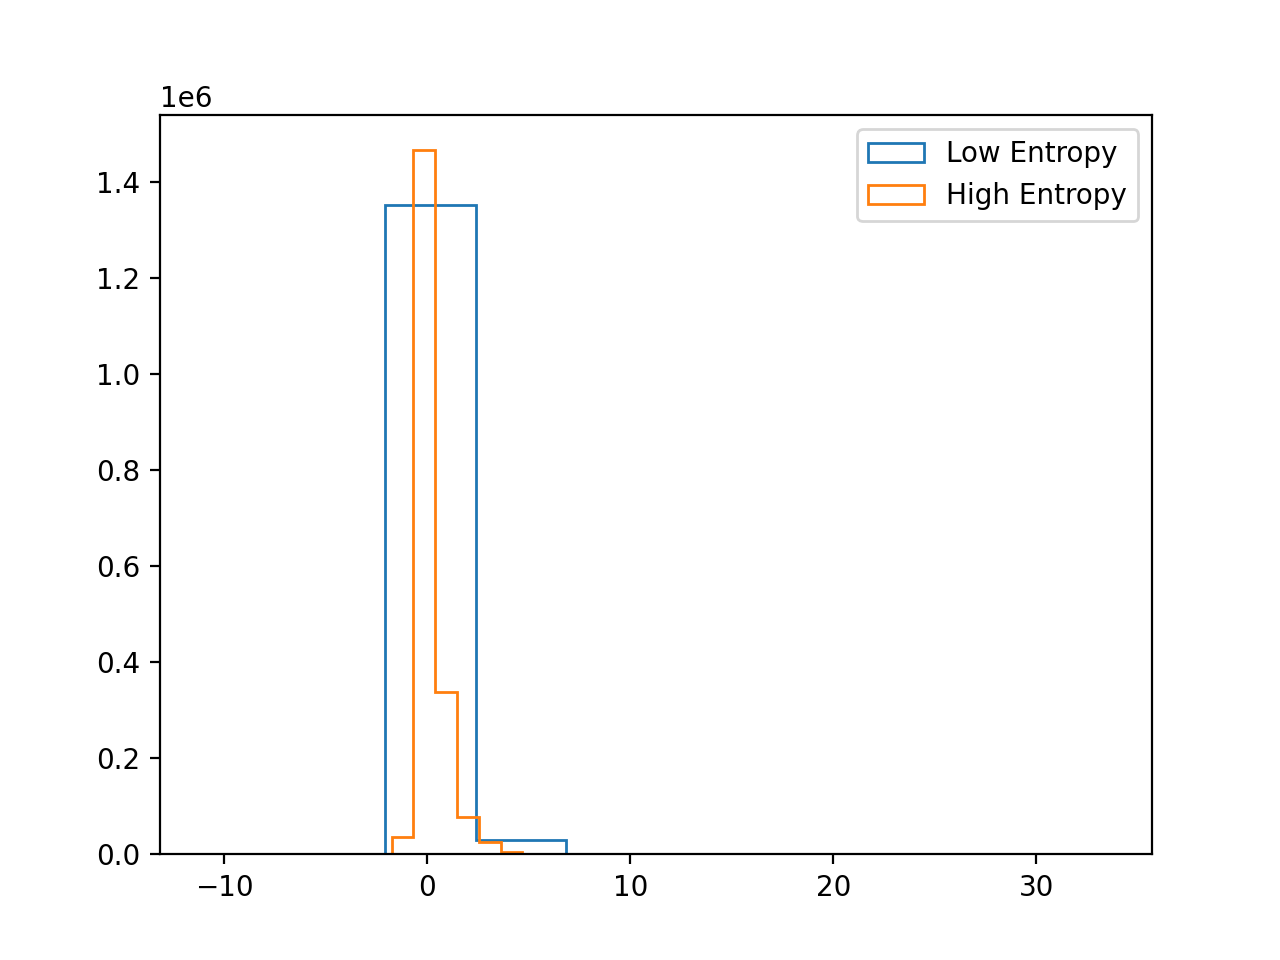

<IPython.core.display.Javascript object>


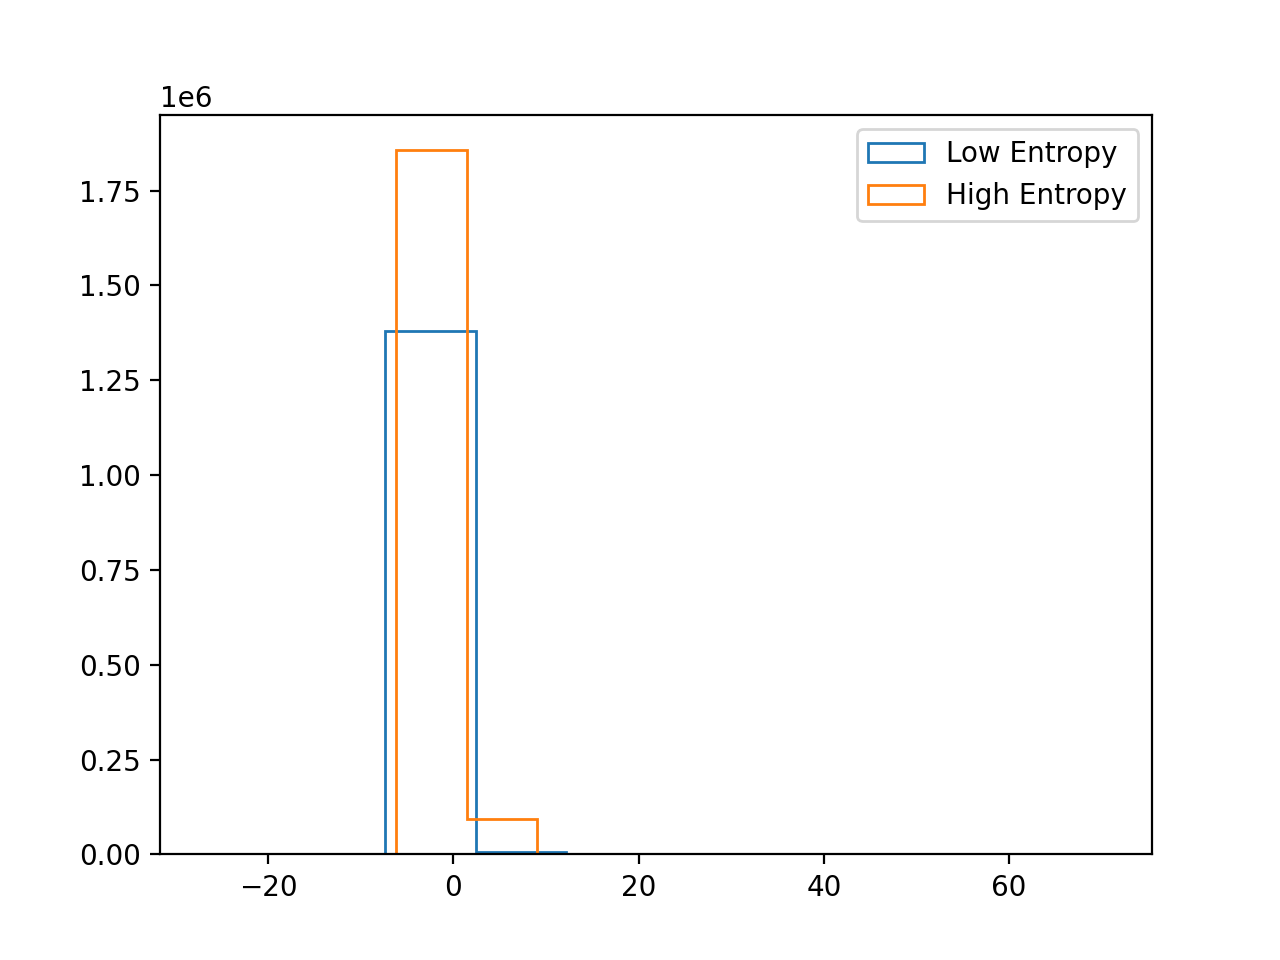

<IPython.core.display.Javascript object>


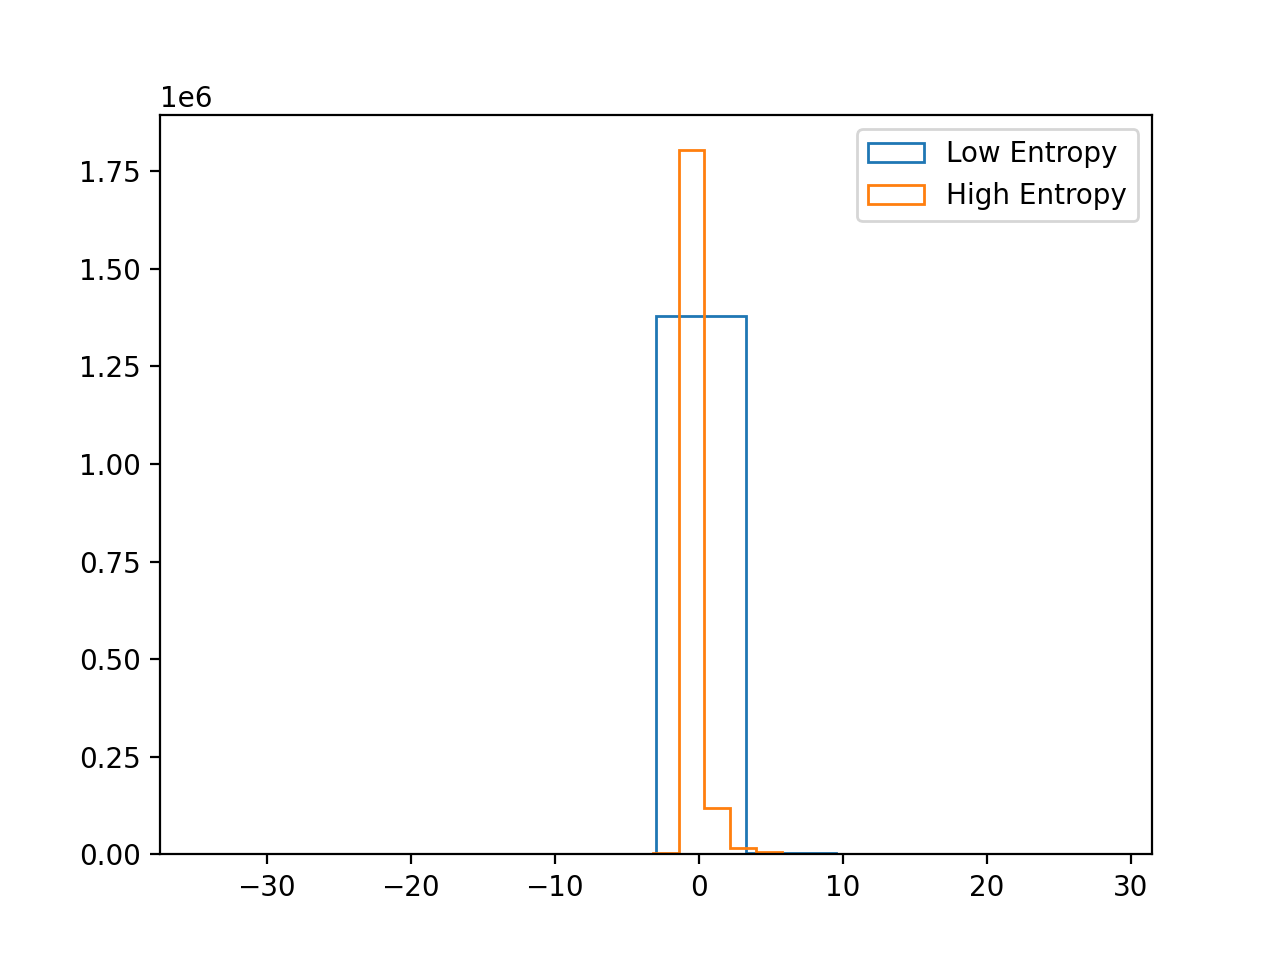

<IPython.core.display.Javascript object>


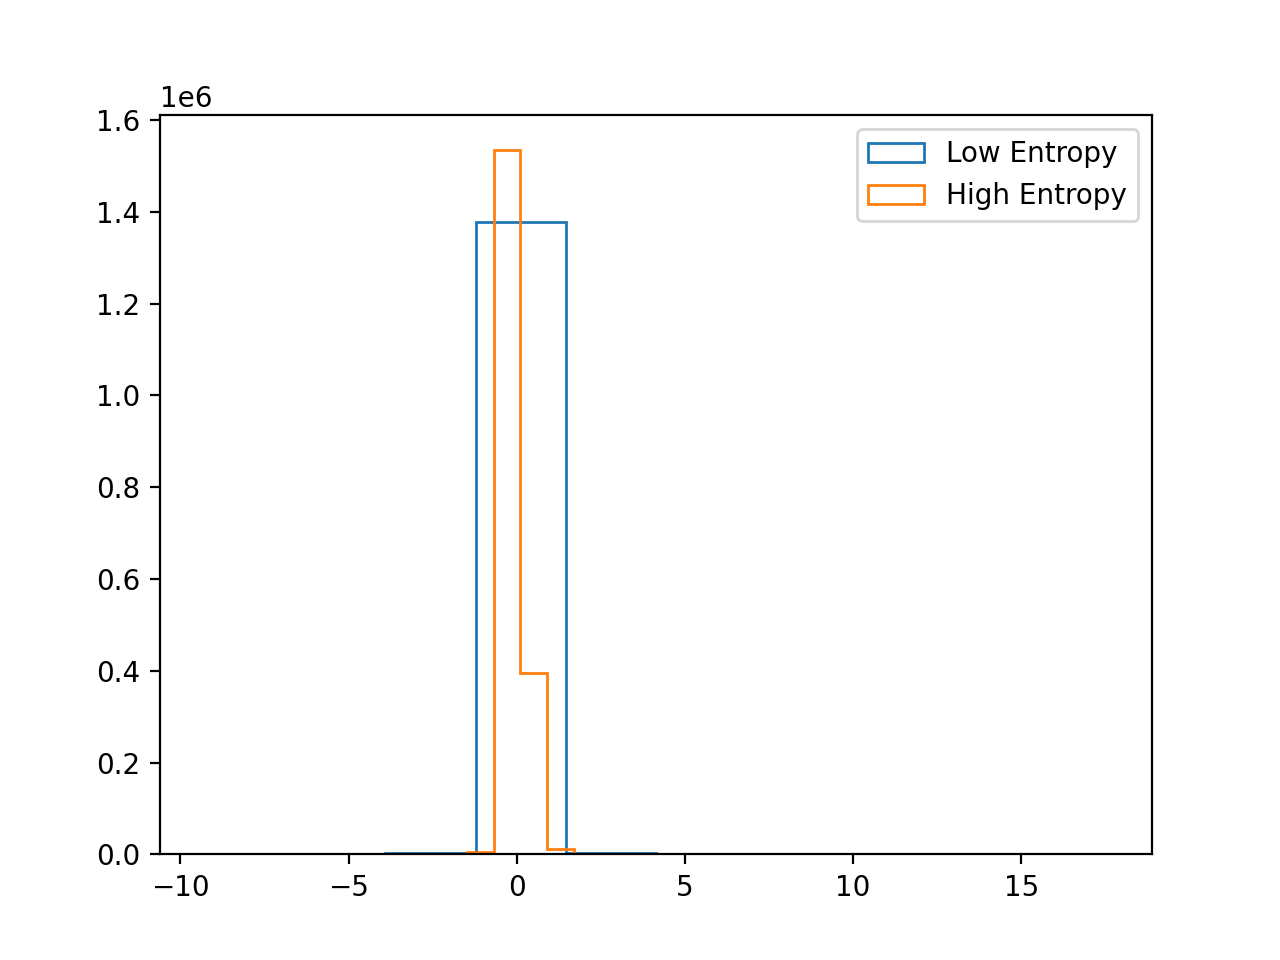

<IPython.core.display.Javascript object>


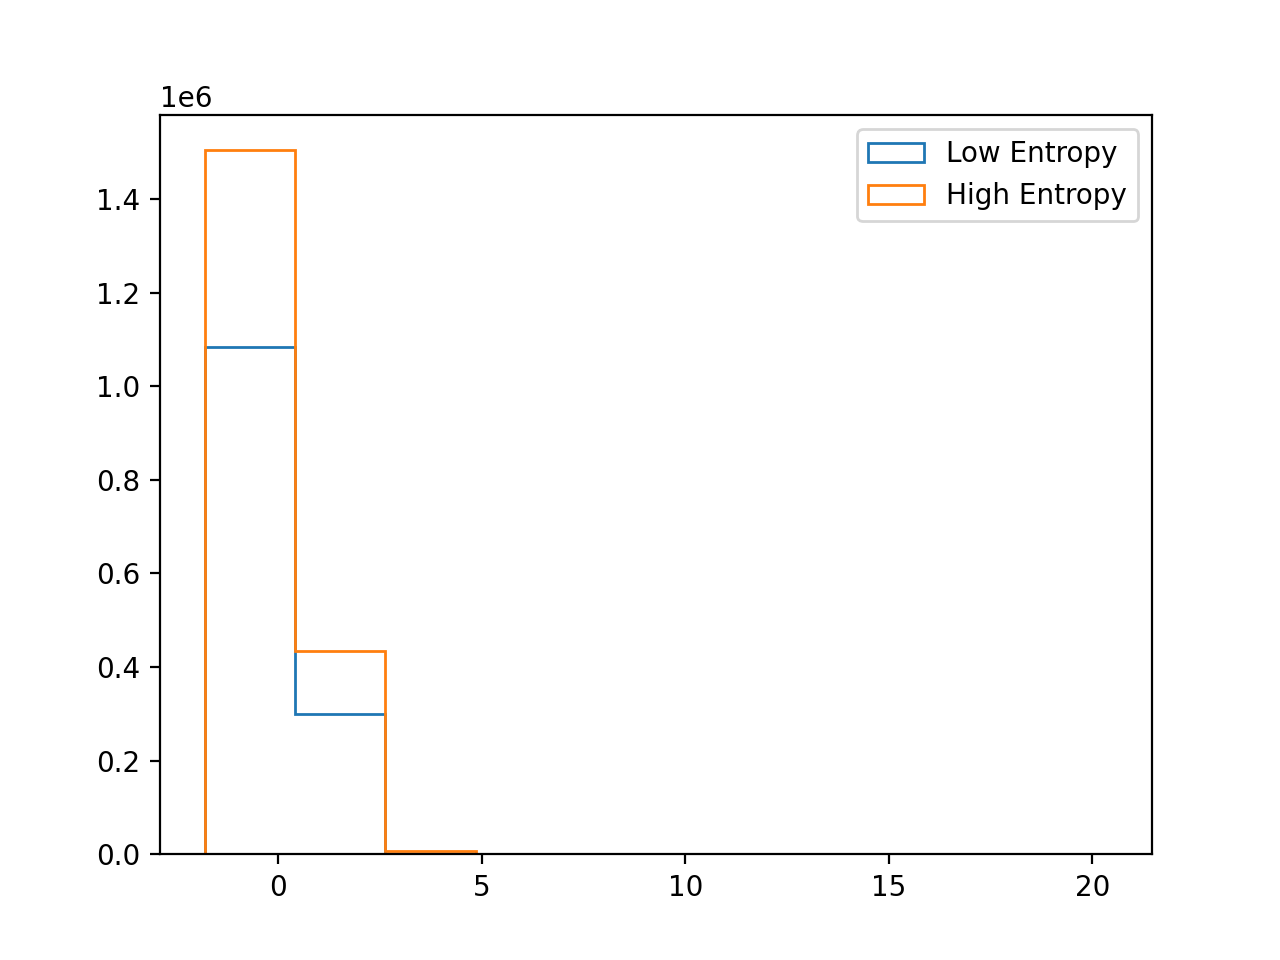

<IPython.core.display.Javascript object>


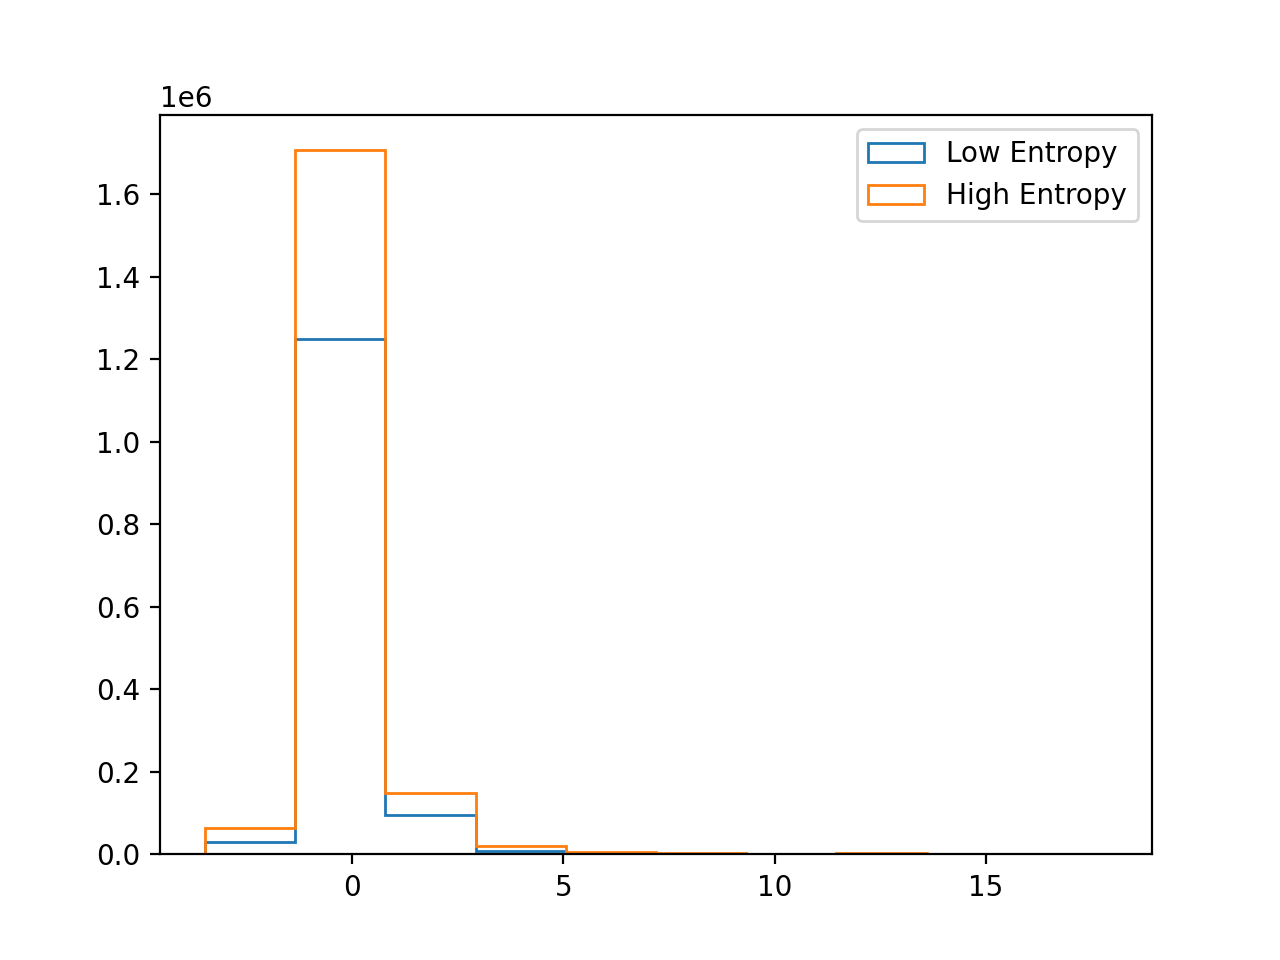

<IPython.core.display.Javascript object>


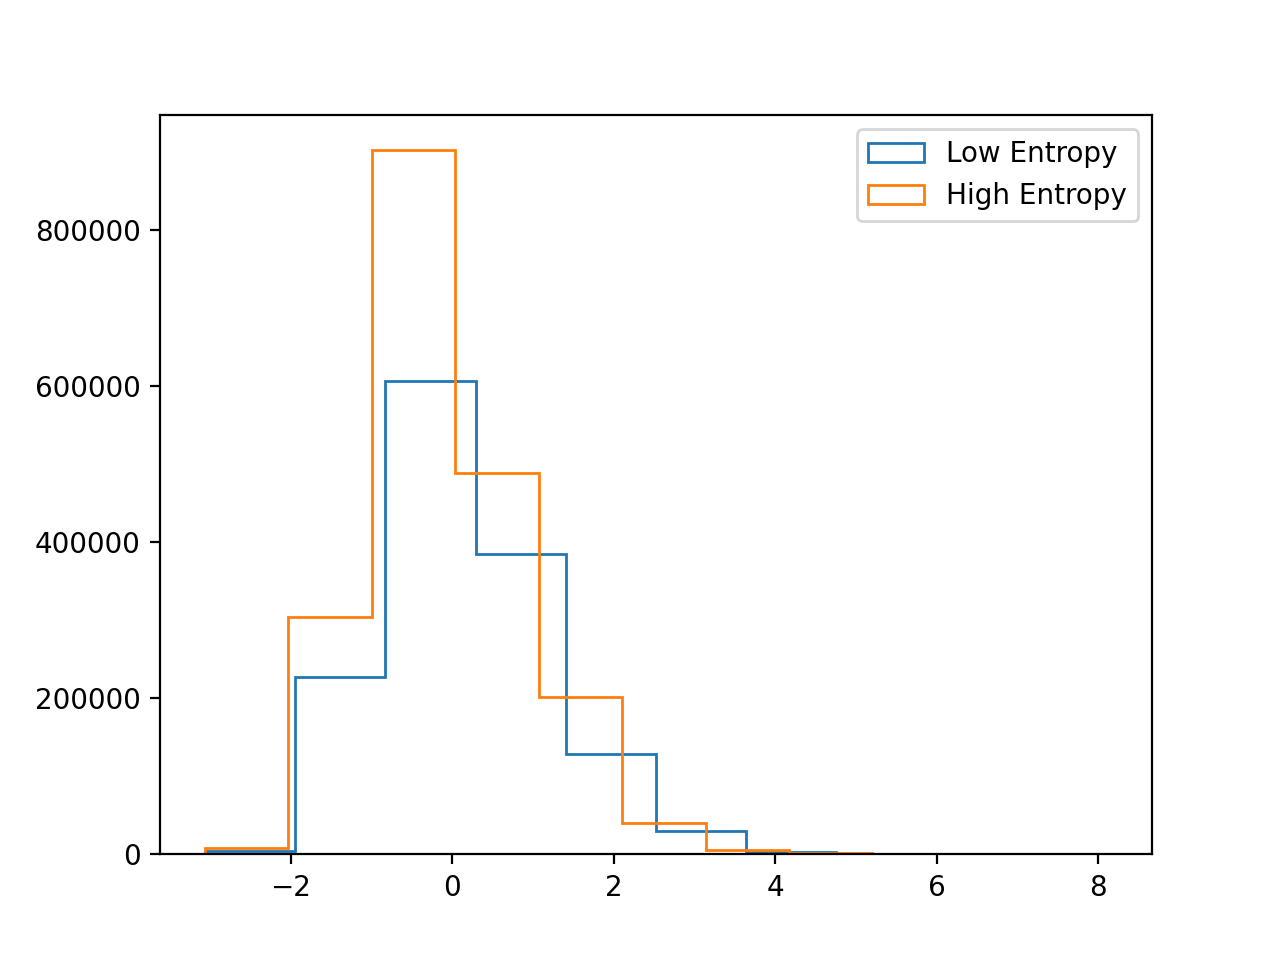

In [42]:
n = x_val.shape[1]
for i in range(n):
    plt.figure()
    plt.hist(x_val[:,i][entropy<= 0.5], histtype ='step', label = 'Low Entropy');
    plt.hist(x_val[:,i][entropy> 0.5], histtype = 'step', label = 'High Entropy');
    plt.legend()